# Import Libraries

In [2]:
import pandas as pd
from numpy import array
import numpy as np
import string
import regex as re
from pickle import dump
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical
#from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
import seaborn as sns
import matplotlib.pyplot as plt

# Loading the Text

In [ ]:
# load doc into memory
def load_doc(filename):
# open the file as read only
  file = open(filename, 'r',encoding = "ISO-8859-1")
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text


In [ ]:
# load document
in_filename = 'game.txt'
doc = load_doc(in_filename)
print(doc[:500])


A Game Of Thrones 
Book One of A Song of Ice and Fire 
By George R. R. Martin 
PROLOGUE 
"We should start back," Gared urged as the woods began to grow dark around them. "The wildlings are 
dead." 
"Do the dead frighten you?" Ser Waymar Royce asked with just the hint of a smile. 
Gared did not rise to the bait. He was an old man, past fifty, and he had seen the lordlings come and go. 
"Dead is dead," he said. "We have no business with the dead." 
"Are they dead?" Royce asked softly. "What proof 


### Clean the Text

In [ ]:
# turn a doc into clean tokens
def clean_doc(doc):
  # replace '--' with a space ' '
  doc = doc.replace('--', ' ')
  # split into tokens by white space
  tokens = doc.split()
  # prepare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  # remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in tokens]
  # remove remaining tokens that are not alphabetic
  tokens = [word for word in tokens if word.isalpha()]
  # make lower case
  tokens = [word.lower() for word in tokens]
  return tokens


In [ ]:
# clean document
tokens = clean_doc(doc)
print(tokens[:200])
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))

['a', 'game', 'of', 'thrones', 'book', 'one', 'of', 'a', 'song', 'of', 'ice', 'and', 'fire', 'by', 'george', 'r', 'r', 'martin', 'prologue', 'we', 'should', 'start', 'back', 'gared', 'urged', 'as', 'the', 'woods', 'began', 'to', 'grow', 'dark', 'around', 'them', 'the', 'wildlings', 'are', 'dead', 'do', 'the', 'dead', 'frighten', 'you', 'ser', 'waymar', 'royce', 'asked', 'with', 'just', 'the', 'hint', 'of', 'a', 'smile', 'gared', 'did', 'not', 'rise', 'to', 'the', 'bait', 'he', 'was', 'an', 'old', 'man', 'past', 'fifty', 'and', 'he', 'had', 'seen', 'the', 'lordlings', 'come', 'and', 'go', 'dead', 'is', 'dead', 'he', 'said', 'we', 'have', 'no', 'business', 'with', 'the', 'dead', 'are', 'they', 'dead', 'royce', 'asked', 'softly', 'what', 'proof', 'have', 'we', 'will', 'saw', 'them', 'gared', 'said', 'if', 'he', 'says', 'they', 'are', 'dead', 'thats', 'proof', 'enough', 'for', 'me', 'will', 'had', 'known', 'they', 'would', 'drag', 'him', 'into', 'the', 'quarrel', 'sooner', 'or', 'later', '

### Visualizing  words in the given document

<BarContainer object of 2 artists>

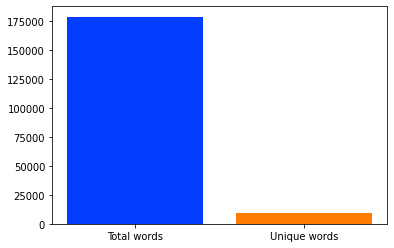

In [ ]:
plt.bar(x = ["Total words", "Unique words"], 
        height=[len(tokens), len(set(tokens))], 
        color=sns.color_palette('bright'))

### Organizing into Sequence of tokens

In [ ]:
# organize into sequences of tokens
length = 50 + 1
sequences = list()
for i in range(length, len(tokens)):
  # select sequence of tokens
  seq = tokens[i-length:i]
  # convert into a line
  line = ' '.join(seq)
  # store
  sequences.append(line)
print('Total Sequences: %d' % len(sequences))

Total Sequences: 178684


In [ ]:
# save tokens to file, one dialog per line
def save_doc(lines, filename):
  data = '\n'.join(lines)
  file = open(filename, 'w')
  file.write(data)
  file.close()
# save sequences to file
out_filename = 'game_sequences.txt'
save_doc(sequences, out_filename)
  

 ###  Encode Sequences 

In [ ]:
# integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

In [ ]:
# vocabulary size
vocab_size = len(tokenizer.word_index) + 1
vocab_size 

9688

In [ ]:
sequences = np.array(sequences)
sequences

array([[   3, 1041,    5, ...,  195,    1, 1952],
       [1041,    5, 1678, ...,    1, 1952,    5],
       [   5, 1678,  970, ..., 1952,    5,    3],
       ...,
       [ 404,    6,   74, ..., 1305,   18,    1],
       [   6,   74,    9, ...,   18,    1, 3641],
       [  74,    9,    6, ...,    1, 3641,   91]])

separate into input and output

In [ ]:
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]


### Model Building and training the model

In [ ]:
# define the model
def define_model(vocab_size, seq_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 50, input_length=seq_length))
  model.add(LSTM(100, return_sequences=True))
  model.add(LSTM(100))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(vocab_size, activation='softmax'))
  # compile network
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  # summarize defined model
  model.summary()
  plot_model(model, to_file='model.png', show_shapes=True)
  return model

In [ ]:
# define model
model = define_model(vocab_size, seq_length)
# fit model
model.fit(X, y, batch_size=128, epochs=80)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            484400    
                                                                 
 lstm (LSTM)                 (None, 50, 100)           60400     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 9688)              978488    
                                                                 
Total params: 1,613,788
Trainable params: 1,613,788
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
1396/1396 [========================

<b> Observation </b>
The model training was taking longer timei.e more than 12 hours.We could achieve  only 44 % accuracy.

In [ ]:
# save the model to file
model.save('model.h5')
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

<b> Testing the language Model <b>

In [8]:
from random import randint
from pickle import load
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences


In [11]:
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text


In [12]:
# generate a sequence from a language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
    # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # predict probabilities for each word
        yhat = model.predict(encoded, verbose=0)
        yhat = np.argmax(yhat,axis=1)
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

In [14]:
# load cleaned text sequences
in_filename = 'game_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')
seq_length = len(lines[0].split()) - 1
# load the model
model = load_model('Model/model.h5')
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))

In [15]:
# select a seed text
seed_text = lines[randint(0,len(lines))]
print(seed_text + '\n')
encoded = tokenizer.texts_to_sequences([seed_text])[0]


that boy of hers needs other children about him and lysa should not be alone in her grief would that i could catelyn said the letter had other tidings the king is riding to winterfell to seek you out it took ned a moment to comprehend her words but when the



In [16]:
# generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print(generated)

understanding came was no littlefinger said but she was a man who used to kill the girl to seek him away from the far end of the summer window awaiting the starks as well as much as much as any horselord them as if she forel meant to frighten them


<b> Observation </b>

 Fairly a decent text generation with 44% accurate language model.